In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import seaborn as sns

# Données

## Chargement

In [2]:
path = './data/diabetes_readmission1'

In [3]:
diabetes = pd.read_csv(path+'/diabetic_data.csv', na_values='?', low_memory=False)

In [4]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
diabetes_map = pd.read_csv(path+'/IDs_mapping.csv')

In [6]:
diabetes_map.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


## Analyse exploratoire

<img src="./data/diabetes_readmission1/Data Dictonary.png">

In [7]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [8]:
diabetes.isna().sum() / len(diabetes)

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

Les NAN sont concentrés sur les variables : <br>
race == 0.022336 % <br>
weight == 0.968585 % <br>
payer_code  == 0.395574 % <br>
medical_specialty ==  0.490822 %<br>
diag_1 ==  0.000206 %<br>
diag_2 ==  0.003518 %<br>
diag_3 ==  0.013983 %<br>

La race n'a pas d'importance ici en France donc on va l'éliminer pour le moment.<br>
Avec 97% de NaN le weight sera exclu <br>
Aussi pour payer_code et medical_specialty, ne sont pas pertinants pour notre contexte. <br>
Par contre pour les diag c'est important, on va essayer de voir comment traiter ces colonnes

### Clé primaire et nombre de patients

In [9]:
diabetes['patient_nbr'].nunique()

71518

**Nombre de patients** : 71 518

In [10]:
diabetes['encounter_id'].nunique()

101766

**encounter_id : clé primaire**

C:\Users\utilisateur\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='encounter_id'>

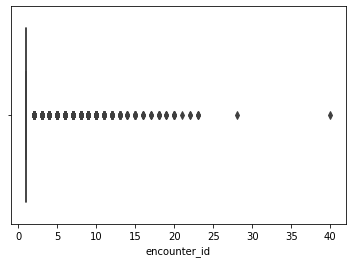

In [11]:
sns.boxplot(diabetes.groupby('patient_nbr')['encounter_id'].count())

In [12]:
diabetes.groupby('patient_nbr')['encounter_id'].count().sort_values(ascending=False).describe()

count    71518.000000
mean         1.422942
std          1.090740
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         40.000000
Name: encounter_id, dtype: float64

In [137]:
#Un patient peut avoir plusieurs admissions :
diabetes[diabetes['patient_nbr']==1660293]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
269,2967810,1660293,Caucasian,Female,[60-70),NaN,6,25,7,10,...,No,Steady,No,No,No,No,No,No,Yes,>30
944,7216812,1660293,Caucasian,Female,[60-70),NaN,6,25,7,4,...,No,Steady,No,No,No,No,No,No,Yes,<30
1077,7977342,1660293,Caucasian,Female,[60-70),NaN,1,1,7,12,...,No,Down,No,No,No,No,No,Ch,Yes,<30
1349,9358128,1660293,Caucasian,Female,[60-70),NaN,1,1,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
2954,18844260,1660293,Caucasian,Female,[60-70),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
3510,21616398,1660293,Caucasian,Female,[60-70),NaN,1,1,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
6780,33120744,1660293,Caucasian,Female,[60-70),NaN,2,1,1,9,...,No,Up,No,No,No,No,No,Ch,Yes,<30
7704,36030504,1660293,Caucasian,Female,[60-70),NaN,2,1,1,5,...,No,Steady,No,No,No,No,No,No,Yes,<30
8547,38486058,1660293,Caucasian,Female,[60-70),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,<30
8972,39749172,1660293,Caucasian,Female,[60-70),NaN,2,1,1,4,...,No,Steady,No,No,No,No,No,No,Yes,>30


### Le genre

In [138]:
# Distributioin du genre
diabetes['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

<AxesSubplot:xlabel='gender', ylabel='Count'>

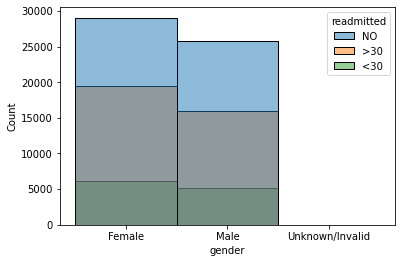

In [15]:
sns.histplot(data=diabetes, x="gender", hue='readmitted')

In [141]:
diabetes['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

<div class="burk">
Utiliser LabelEncoder pour gender <br>
Enlever les 3 valeurs Unknown/Invalid
</div><i class="fa fa-lightbulb-o "></i>

### l'âge

<AxesSubplot:xlabel='age', ylabel='Count'>

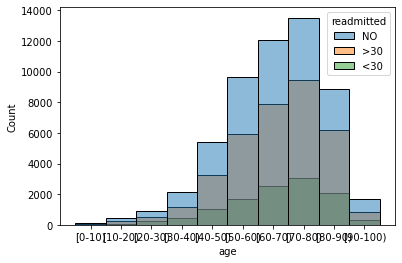

In [17]:
# Distribution de l'âge
sns.histplot(data=diabetes, x="age", hue='readmitted')

In [18]:
diabetes['age'].value_counts(normalize=True)

[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64

In [19]:
diabetes['age'].describe(include=all)

count      101766
unique         10
top       [70-80)
freq        26068
Name: age, dtype: object

In [20]:
diabetes['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

Age : LabelEncoder with 10 graduation : 5, 15, ... 95 or (LabelEncoder * 10) + 5

### admission_type_id, discharge & source

Les trois colonnes scontiennent beaucoup d'information mais nécissitent un traitement

In [21]:
diabetes['admission_type_id'].unique()

array([6, 1, 2, 3, 4, 5, 8, 7], dtype=int64)

Traitement du deuxième dataset qui contient les infos sur les admissions 

In [22]:
diabetes_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   admission_type_id  65 non-null     object
 1   description        62 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [23]:
diabetes_map.isna().sum()

admission_type_id    2
description          5
dtype: int64

In [24]:
diabetes_map['admission_type_id'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', nan,
       'discharge_disposition_id', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '30', '27', '28', '29', 'admission_source_id'], dtype=object)

In [25]:
diabetes_map['description'].unique()

array(['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', nan,
       'Trauma Center', 'Not Mapped', 'description', 'Discharged to home',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to SNF', 'Discharged/transferred to ICF',
       'Discharged/transferred to another type of inpatient care institution',
       'Discharged/transferred to home with home health service',
       'Left AMA',
       'Discharged/transferred to home under care of Home IV provider',
       'Admitted as an inpatient to this hospital',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Expired',
       'Still patient or expected to return for outpatient services',
       'Hospice / home', 'Hospice / medical facility',
       'Discharged/transferred within this institution to Medicare approved swing bed',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/refer

In [26]:
diabetes_map.shape

(67, 2)

In [27]:
# Le dataset est structuré en 3 blocs en ligne, qu'il faut spliter :
diabetes_map = diabetes_map.dropna(axis=0).reset_index(drop=True)
diabetes_map.head(50)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,7,Trauma Center
6,8,Not Mapped
7,discharge_disposition_id,description
8,1,Discharged to home
9,2,Discharged/transferred to another short term h...


#### Split the diabetes_map

Etape 1 : spliter le dataset <br>
Etape 2 : transformer object in intiger

In [28]:
d_admission_type_id = diabetes_map.iloc[:7,:]
d_admission_type_id['admission_type_id'] = d_admission_type_id['admission_type_id'].astype('int8')
d_admission_type_id

<ipython-input-28-67d36da6e6f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_admission_type_id['admission_type_id'] = d_admission_type_id['admission_type_id'].astype('int8')


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,7,Trauma Center
6,8,Not Mapped


In [29]:
d_discharge_disposition_id = diabetes_map.iloc[8:37,:]
d_discharge_disposition_id['admission_type_id'] = d_discharge_disposition_id['admission_type_id'].astype('int8')
d_discharge_disposition_id.columns = ['discharge_disposition_id', 'description']
d_discharge_disposition_id

<ipython-input-29-7c9097af28d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_discharge_disposition_id['admission_type_id'] = d_discharge_disposition_id['admission_type_id'].astype('int8')


,discharge_disposition_id,description
8,1,Discharged to home
9,2,Discharged/transferred to another short term h...
10,3,Discharged/transferred to SNF
11,4,Discharged/transferred to ICF
12,5,Discharged/transferred to another type of inpa...
13,6,Discharged/transferred to home with home healt...
14,7,Left AMA
15,8,Discharged/transferred to home under care of H...
16,9,Admitted as an inpatient to this hospital
17,10,Neonate discharged to another hospital for neo...


In [30]:
d_admission_source_id = diabetes_map.iloc[38:,:]
d_admission_source_id['admission_type_id'] = d_admission_source_id['admission_type_id'].astype('int8')
d_admission_source_id.columns = ['admission_source_id', 'description']
d_admission_source_id

<ipython-input-30-7232a3dbac86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_admission_source_id['admission_type_id'] = d_admission_source_id['admission_type_id'].astype('int8')


,admission_source_id,description
38,1,Physician Referral
39,2,Clinic Referral
40,3,HMO Referral
41,4,Transfer from a hospital
42,5,Transfer from a Skilled Nursing Facility (SNF)
43,6,Transfer from another health care facility
44,7,Emergency Room
45,8,Court/Law Enforcement
46,9,Not Available
47,10,Transfer from critial access hospital


<AxesSubplot:>

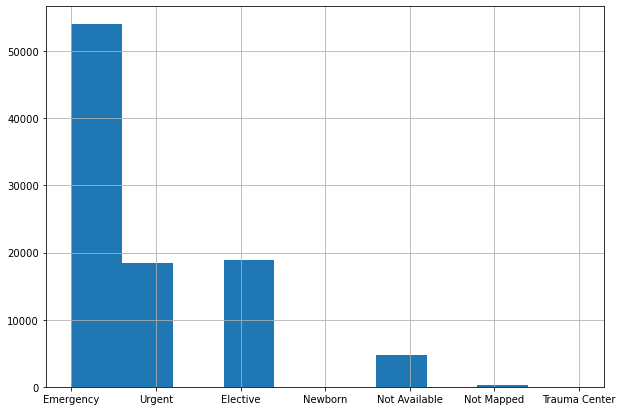

In [31]:
plt.subplots(figsize=(10,7))
diabetes.merge(d_admission_type_id, 
                                 how='left', 
                                 on='admission_type_id')['description'].hist()

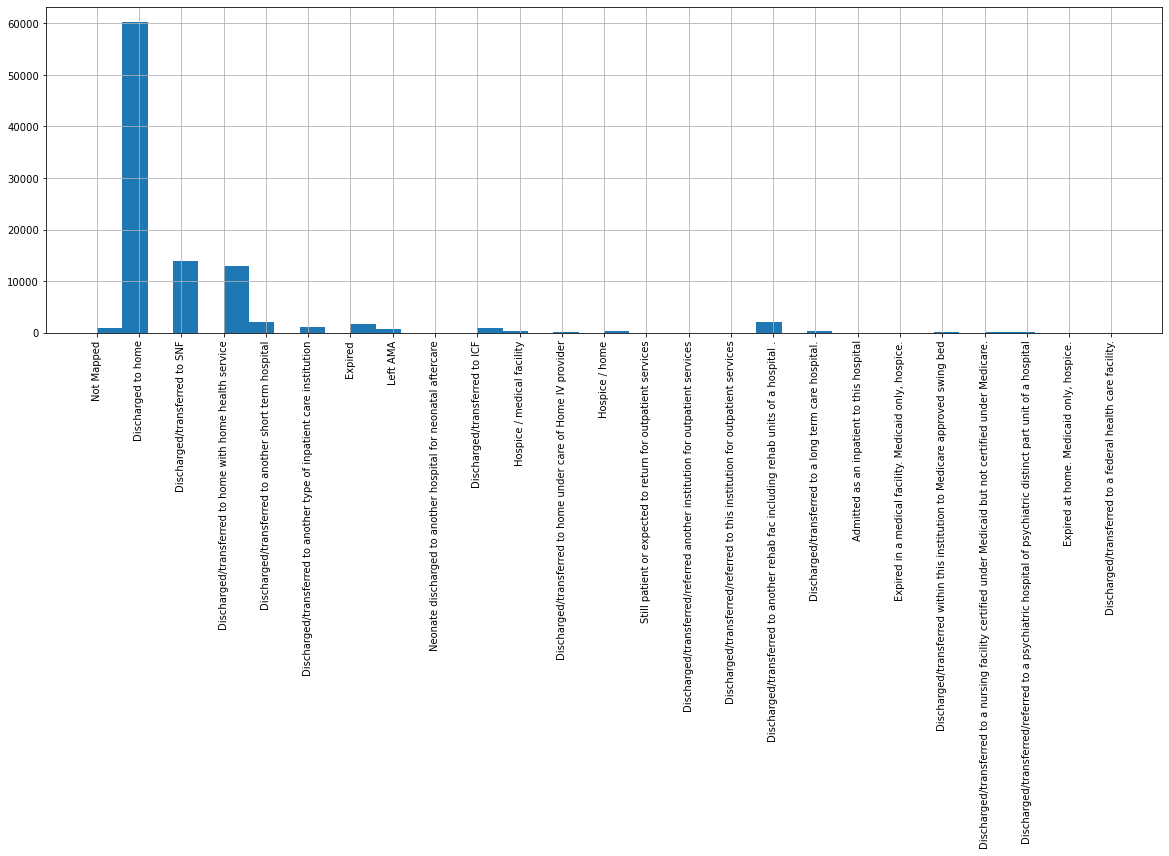

In [32]:
plt.subplots(figsize=(20,6))
diabetes.merge(d_discharge_disposition_id, 
                                 how='left', 
                                 on='discharge_disposition_id')['description'].hist(bins=40)
plt.xticks(rotation='vertical');

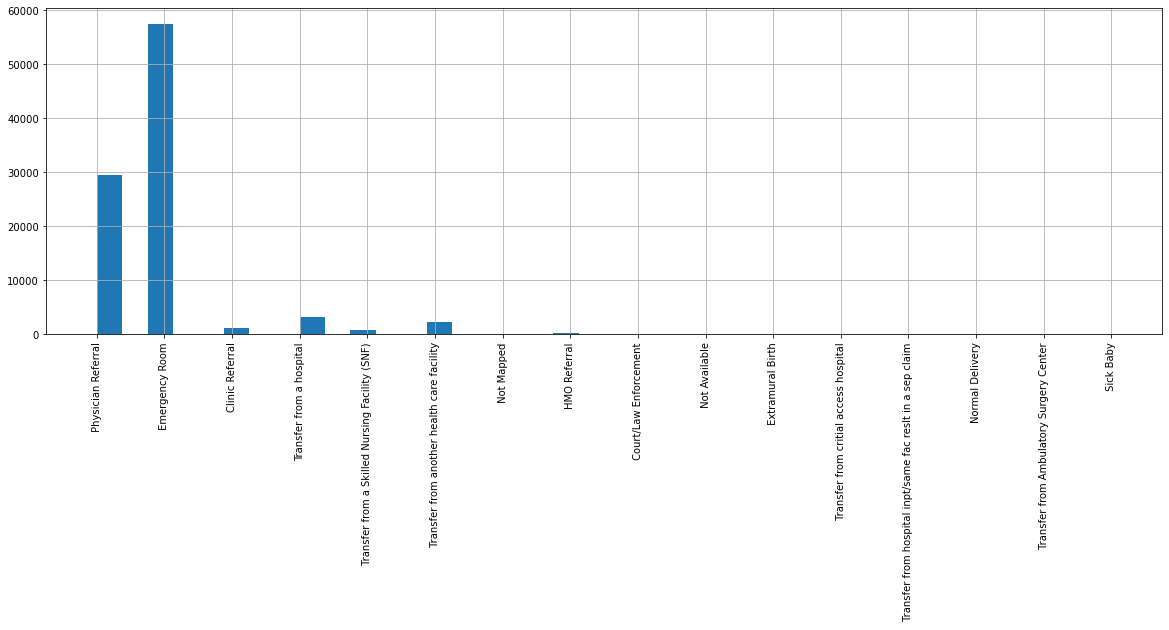

In [33]:
plt.subplots(figsize=(20,6))
diabetes.merge(d_admission_source_id, 
                                 how='left', 
                                 on='admission_source_id')['description'].hist(bins=40)
plt.xticks(rotation='vertical');

### time_in_hospital

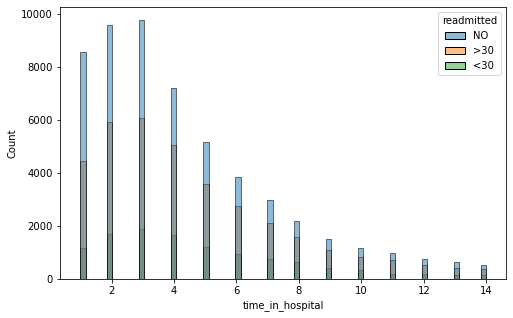

In [34]:
plt.subplots(figsize=(8,5))
sns.histplot(data=diabetes, x="time_in_hospital", hue='readmitted');

Le nombre de jours resté à l'hopital

### payer_code (pas imprtant)

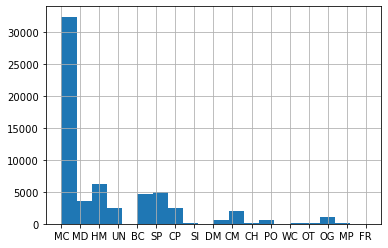

In [35]:
diabetes['payer_code'].hist(bins=20);

### medical_specialty

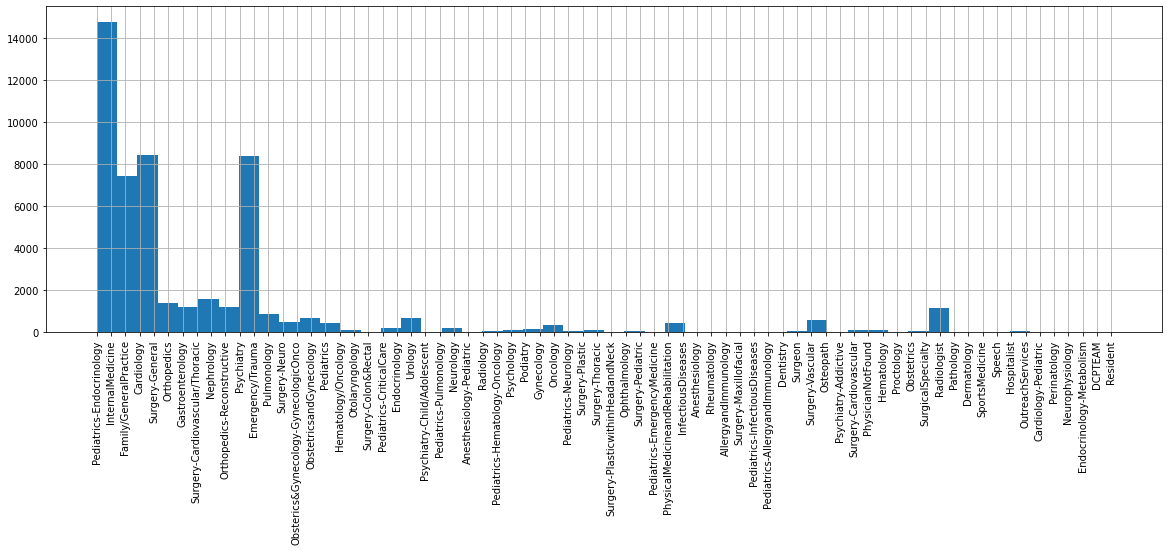

In [36]:
plt.subplots(figsize=(20,6))
diabetes['medical_specialty'].hist(bins=50)
plt.xticks(rotation='vertical');

### Colonnes numérqiues : lab_procedures, procedures, medications, outpatient, emergency, inpatient

In [37]:
diabetes.columns[12:18]

Index(['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient'],
      dtype='object')

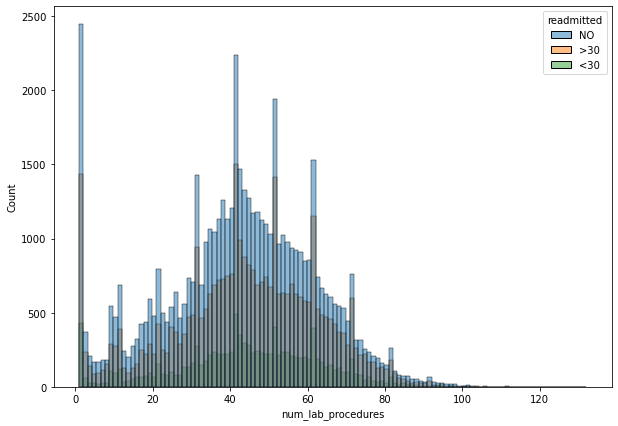

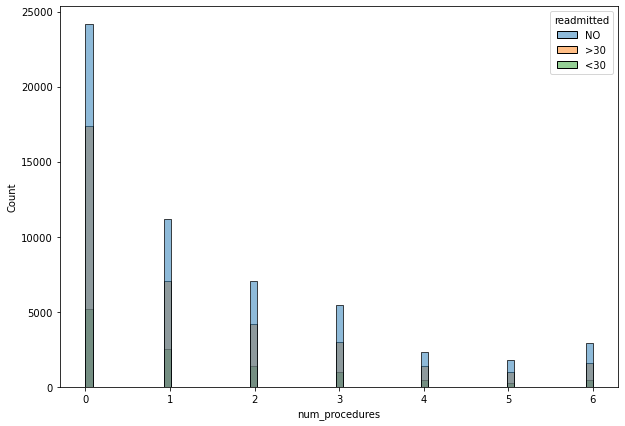

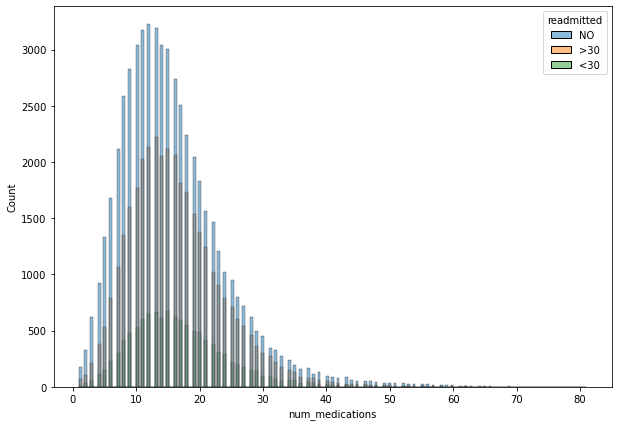

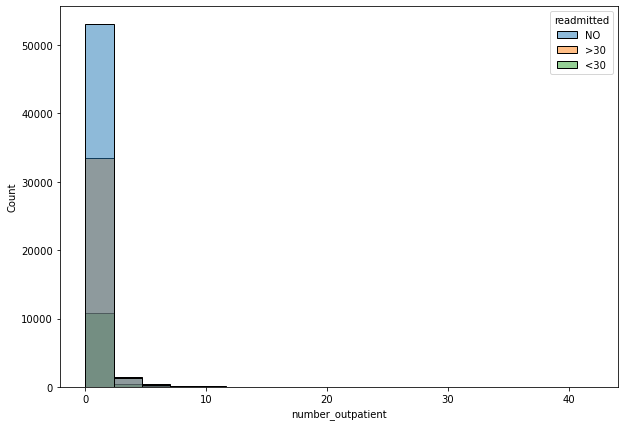

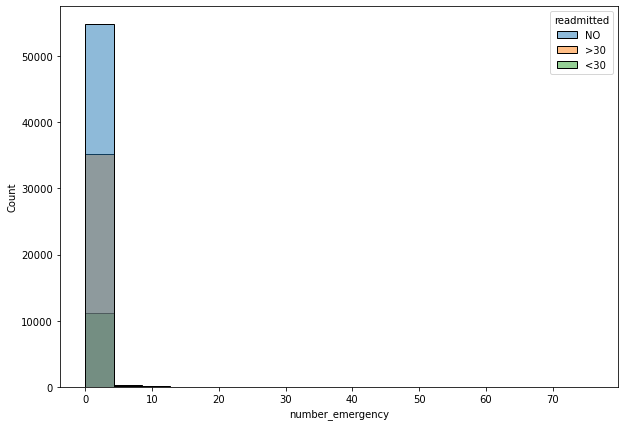

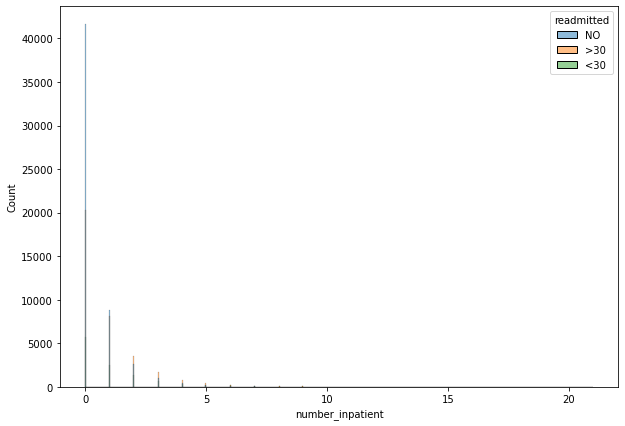

In [39]:
for col in diabetes.columns[12:18]:
    plt.subplots(figsize=(10,7))
    sns.histplot(data=diabetes, x=col, hue='readmitted');

### Diagnostiques

Classification ICD9

In [40]:
diabetes.columns[18:22]

Index(['diag_1', 'diag_2', 'diag_3', 'number_diagnoses'], dtype='object')

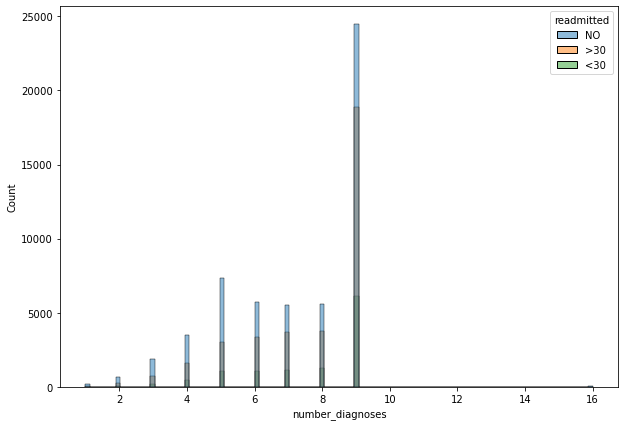

In [41]:
sns.color_palette("magma")
plt.subplots(figsize=(10,7))
sns.histplot(data=diabetes, x='number_diagnoses', hue='readmitted');

In [42]:
for col in diabetes.columns[18:21]:
    print(col, ' : ', diabetes[col].nunique())

diag_1  :  716
diag_2  :  748
diag_3  :  789


In [43]:
diabetes['diag_1']

0         250.83
1            276
2            648
3              8
4            197
           ...  
101761    250.13
101762       560
101763        38
101764       996
101765       530
Name: diag_1, Length: 101766, dtype: object

le nobre de modalités est très grand et il peut s'avérer compliqué de les traiter. <br>
Une des piste est de les classer en utilisant le système ICD9

### Les tests (max_glu_serum, A1Cresult      )

On a disposition deux colonnes de tests

<AxesSubplot:>

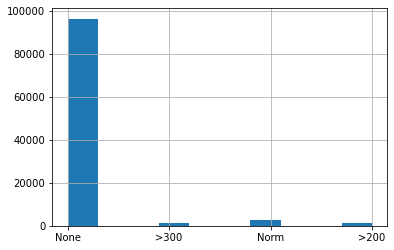

In [44]:
diabetes['max_glu_serum'].hist()

In [45]:
diabetes['max_glu_serum'].value_counts(normalize=True)

None    0.947468
Norm    0.025519
>200    0.014592
>300    0.012421
Name: max_glu_serum, dtype: float64

In [142]:
diabetes['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

<AxesSubplot:>

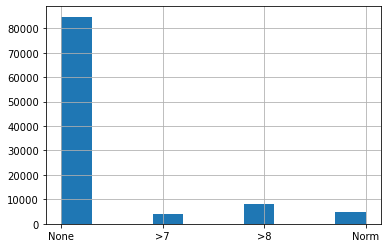

In [46]:
diabetes['A1Cresult'].hist()

In [47]:
diabetes['A1Cresult'].value_counts(normalize=True)

None    0.832773
>8      0.080734
Norm    0.049034
>7      0.037458
Name: A1Cresult, dtype: float64

In [143]:
diabetes['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

La majorité des tests sont None i.e. pas de mesure ce qui signifie que leur utilisation n'est pas possible

### Medications

In [48]:
diabetes.columns[24:-3]

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

In [145]:
diabetes.iloc[:,24:-3]

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
2,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
4,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,Steady,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Down,No,No,No,No,No
101762,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No
101763,Steady,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Down,No,No,No,No,No
101764,No,No,No,No,No,No,Steady,No,No,Steady,...,No,No,No,No,Up,No,No,No,No,No


In [50]:
li = []
for col in diabetes.columns[24:-3]:
    a = pd.DataFrame(diabetes[col].value_counts())
    li.append(a)

In [51]:
medication = pd.concat(li, axis=1)
medication

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
No,81778,100227,101063,101680,96575,101765.0,89080,91116,101743.0,94438,...,101763.0,101727.0,101766.0,101766.0,47383,101060,101753.0,101765.0,101764.0,101765.0
Steady,18346,1384,668,79,4670,1.0,11356,9274,23.0,6976,...,3.0,38.0,NaN,NaN,30849,692,13.0,1.0,2.0,1.0
Up,1067,110,24,6,327,NaN,770,812,NaN,234,...,NaN,1.0,NaN,NaN,11316,8,NaN,NaN,NaN,NaN
Down,575,45,11,1,194,NaN,560,564,NaN,118,...,NaN,NaN,NaN,NaN,12218,6,NaN,NaN,NaN,NaN


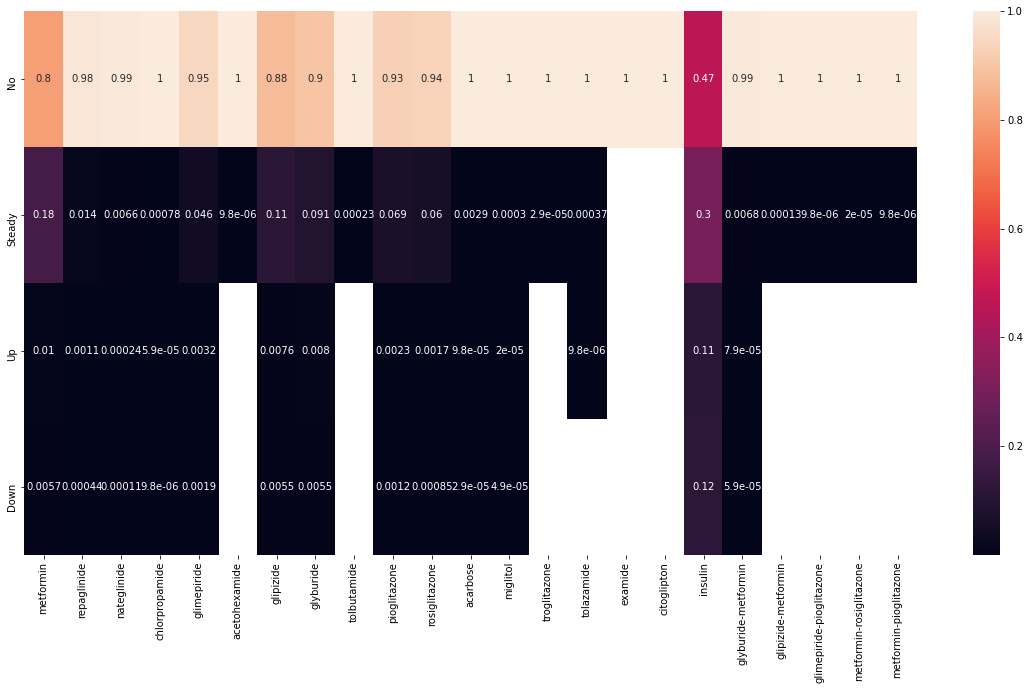

In [52]:
plt.subplots(figsize=(20,10))
sns.heatmap(medication / len(diabetes), annot=True);

Cette partie médicaments est très intéressante mais nécessite beaucoup de traitement pour une bonne utilisatio. On se limitera aux deux médiacaments les plus consommés.

<AxesSubplot:>

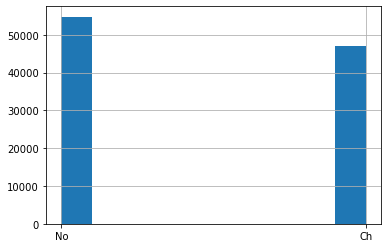

In [53]:
# Cette colonne indique si il y a changement dans les médicaments du patient
diabetes.change.hist()

### diabetesMed

Indicates if there was any diabetic medications prescribed. Value "yes" and "No"

<AxesSubplot:>

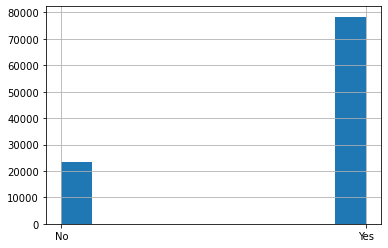

In [54]:
diabetes.diabetesMed.hist()

In [55]:
diabetes.diabetesMed.value_counts(normalize=True)

Yes    0.770031
No     0.229969
Name: diabetesMed, dtype: float64

### Target : readmitted

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64


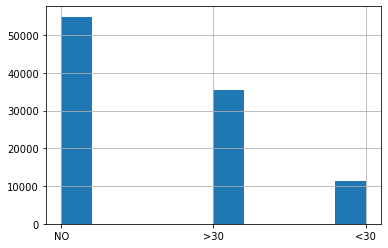

In [56]:
print(diabetes.iloc[:,-1].value_counts(normalize=True))
diabetes.iloc[:,-1].hist();

Classes non équilibrées

### Relations entre les variables nuériques avant encodage

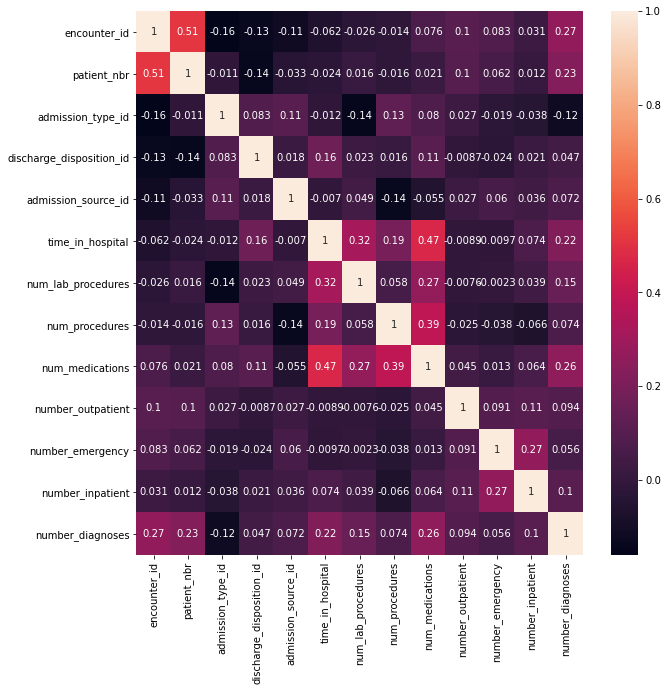

In [57]:
# Corrélations avant encodage donc par la target
plt.subplots(figsize=(10,10))
sns.heatmap(diabetes.corr(), annot=True);

### Synthèse de la phase exploratoire

* 'encounter_id', 'patient_nbr' pas utiles <br>
**Missing values :<br>**
* Eliminer : race, weight, payer_code, medical_specialty<br>
* diag_1, diag_2, diag_3 peu de missing mais utilisation compliquée car ils possèdent plus de 700 diagonstiques pour chaque classe ?? <br>
**Variables numérique**
* Variables numériques intéressantes à garder en l'état :<br>
'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',    'number_outpatient', 'number_emergency', 'number_inpatient'

**Admission**
* Merge avec les dataframes puis *OneHotEncoder*<br>

**Encodage simple** : gender, age, change, diabetesMed, readmitted<br>

**Encodage pas évident** 
>: medication ? 23 médicaments possibles <br>
>: les 2 tests (94% 0.83%) n'ont pas de mesures


## Preprocessing

### Missing values & séléction des variables

In [59]:
diabete = diabetes.copy()

On ne va séléctionner que les variables qui ont le plus de sens et qui peuvent être traitées facilement sans trop d'interprétation : les variables à encodage simple, les variables numériques. D'autres variables seront traitées au fur et à mesure

In [60]:
diabete = diabete[['gender', 
                   'age', 
                   'time_in_hospital', 
                   'num_lab_procedures', 
                   'num_procedures', 
                   'num_medications',
                   'number_outpatient', 
                   'number_emergency', 
                   'number_inpatient', 
                   'change', 
                   'diabetesMed']]
diabete.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,change,diabetesMed
0,Female,[0-10),1,41,0,1,0,0,0,No,No
1,Female,[10-20),3,59,0,18,0,0,0,Ch,Yes
2,Female,[20-30),2,11,5,13,2,0,1,No,Yes
3,Male,[30-40),2,44,1,16,0,0,0,Ch,Yes
4,Male,[40-50),1,51,0,8,0,0,0,Ch,Yes


### Encodage

#### LabelEncodage

In [61]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

In [66]:
label = LabelEncoder()
diabete.gender = label.fit_transform(diabete.gender)

In [67]:
diabete.change = label.fit_transform(diabete.change)

In [68]:
diabete.diabetesMed = label.fit_transform(diabete.diabetesMed)

#### Encodage de l'âge

In [69]:
diabete.age.astype("category").cat.categories

Index(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
      dtype='object')

In [70]:
diabete.age = diabete.age.astype("category").cat.rename_categories(list(5 + np.arange(0,10) * 10))

In [71]:
diabete.age.values

[5, 15, 25, 35, 45, ..., 75, 85, 75, 85, 75]
Length: 101766
Categories (10, int64): [5, 15, 25, 35, ..., 65, 75, 85, 95]

In [72]:
diabete.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,change,diabetesMed
0,0,5,1,41,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,0,1
2,0,25,2,11,5,13,2,0,1,1,1
3,1,35,2,44,1,16,0,0,0,0,1
4,1,45,1,51,0,8,0,0,0,0,1


In [73]:
diabete.age

0          5
1         15
2         25
3         35
4         45
          ..
101761    75
101762    85
101763    75
101764    85
101765    75
Name: age, Length: 101766, dtype: category
Categories (10, int64): [5, 15, 25, 35, ..., 65, 75, 85, 95]

#### OneHotEncoder

##### Colonnes admission

<AxesSubplot:>

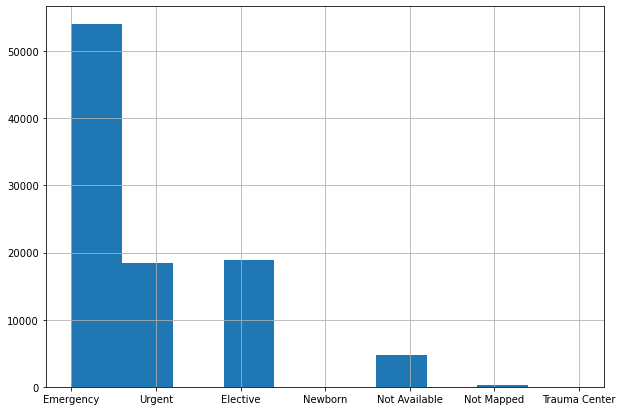

In [74]:
plt.subplots(figsize=(10,7))
diabetes.merge(d_admission_type_id, 
                                 how='left', 
                                 on='admission_type_id')['description'].hist()

In [75]:
col1 = diabetes.merge(d_admission_type_id, 
                                 how='left', 
                                 on='admission_type_id')['description']
col1.unique()

array([nan, 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available',
       'Not Mapped', 'Trauma Center'], dtype=object)

les valeurs NaN sont dues au néttoyage du 2ème dataset où la valeur 6 correspondait à NaN

In [76]:
col1 = col1.fillna('cat6')

In [77]:
oneHot = OneHotEncoder(handle_unknown='ignore')
oh_admission_type = pd.DataFrame(
    oneHot.fit_transform(col1.values.reshape((len(col1),1))).toarray(), 
    columns = oneHot.categories_)
oh_admission_type.head()

,Elective,Emergency,Newborn,Not Available,Not Mapped,Trauma Center,Urgent,cat6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
oh_admission_type.sum(axis=0)

Elective         18869.0
Emergency        53990.0
Newborn             10.0
Not Available     4785.0
Not Mapped         320.0
Trauma Center       21.0
Urgent           18480.0
cat6              5291.0
dtype: float64

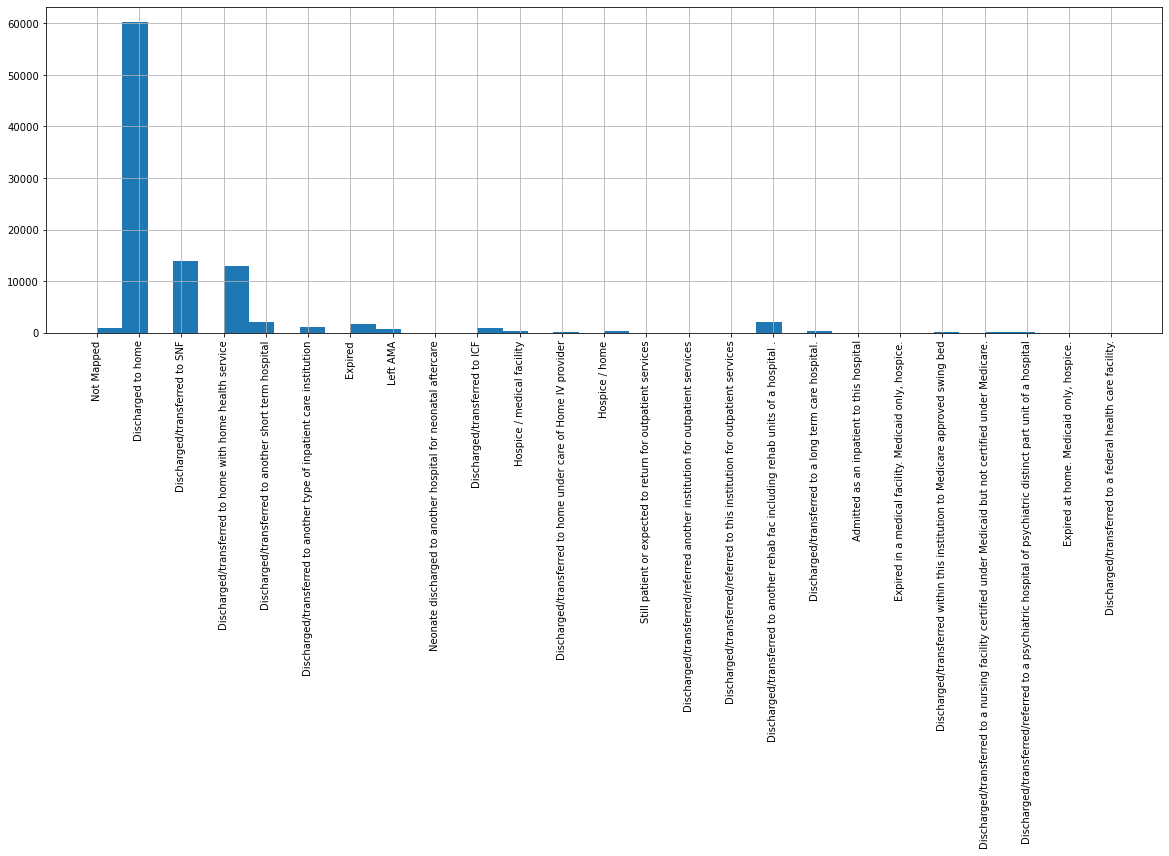

In [79]:
plt.subplots(figsize=(20,6))
diabetes.merge(d_discharge_disposition_id, 
                                 how='left', 
                                 on='discharge_disposition_id')['description'].hist(bins=40)
plt.xticks(rotation='vertical');

In [80]:
col2 = diabetes.merge(d_discharge_disposition_id, 
                                 how='left', 
                                 on='discharge_disposition_id')['description']
col2 = col2.fillna('catNaN')

In [81]:
oneHot2 = OneHotEncoder(handle_unknown='ignore')
oh_discharge_disposition = pd.DataFrame(
    oneHot2.fit_transform(col2.values.reshape((len(col2),1))).toarray(), 
    columns = oneHot2.categories_)
oh_discharge_disposition.head()

,Admitted as an inpatient to this hospital,Discharged to home,Discharged/transferred to ICF,Discharged/transferred to SNF,Discharged/transferred to a federal health care facility.,Discharged/transferred to a long term care hospital.,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,Discharged/transferred to another rehab fac including rehab units of a hospital .,Discharged/transferred to another short term hospital,Discharged/transferred to another type of inpatient care institution,...,Expired,"Expired at home. Medicaid only, hospice.","Expired in a medical facility. Medicaid only, hospice.",Hospice / home,Hospice / medical facility,Left AMA,Neonate discharged to another hospital for neonatal aftercare,Not Mapped,Still patient or expected to return for outpatient services,catNaN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
oh_discharge_disposition.sum(axis=0)

Admitted as an inpatient to this hospital                                                                       21.0
Discharged to home                                                                                           60234.0
Discharged/transferred to ICF                                                                                  815.0
Discharged/transferred to SNF                                                                                13954.0
Discharged/transferred to a federal health care facility.                                                        5.0
Discharged/transferred to a long term care hospital.                                                           412.0
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.         48.0
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993.0
Discharged/transferred to another short term hospital           

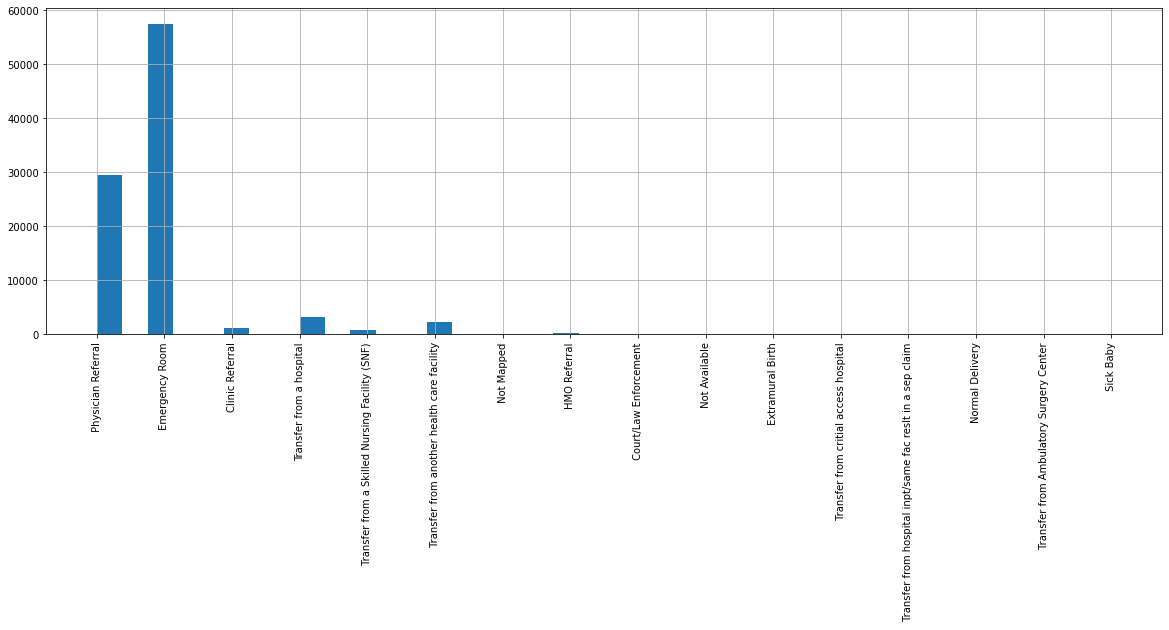

In [83]:
# d_admission_source_id
plt.subplots(figsize=(20,6))
diabetes.merge(d_admission_source_id, 
                                 how='left', 
                                 on='admission_source_id')['description'].hist(bins=40)
plt.xticks(rotation='vertical');

In [84]:
col3 = diabetes.merge(d_admission_source_id, 
                                 how='left', 
                                 on='admission_source_id')['description']
col3 = col3.fillna('catNaN')

In [85]:
oneHot3 = OneHotEncoder(handle_unknown='ignore')
oh_admission_source = pd.DataFrame(
    oneHot3.fit_transform(col3.values.reshape((len(col3),1))).toarray(), 
    columns = oneHot3.categories_)
oh_admission_source.head()

,Court/Law Enforcement,Emergency Room,Extramural Birth,Not Available,Not Mapped,Physician Referral,Sick Baby,Transfer from Ambulatory Surgery Center,Transfer from a Skilled Nursing Facility (SNF),Transfer from another health care facility,Transfer from critial access hospital,Transfer from hospital inpt/same fac reslt in a sep claim,Clinic Referral,HMO Referral,Normal Delivery,Transfer from a hospital,catNaN
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
oh_admission_source.sum(axis=0)

 Court/Law Enforcement                                           16.0
 Emergency Room                                               57494.0
 Extramural Birth                                                 2.0
 Not Available                                                  125.0
 Not Mapped                                                     161.0
 Physician Referral                                           29565.0
 Sick Baby                                                        1.0
 Transfer from Ambulatory Surgery Center                          2.0
 Transfer from a Skilled Nursing Facility (SNF)                 855.0
 Transfer from another health care facility                    2264.0
 Transfer from critial access hospital                            8.0
 Transfer from hospital inpt/same fac reslt in a sep claim       12.0
Clinic Referral                                                1104.0
HMO Referral                                                    187.0
Normal Delivery     

##### Colonnes médicaments

In [87]:
diabetes.iloc[:,24:-3].columns

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

On va exploiter les deux médicaments les plus utilisés : metformin, insulin

In [88]:
oneHot4 = OneHotEncoder(handle_unknown='ignore')
oh_metformin = pd.DataFrame(
    oneHot4.fit_transform(diabetes['metformin'].values.reshape((len(col3),1))).toarray(), 
    columns = oneHot4.categories_)
oh_metformin.head()

,Down,No,Steady,Up
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [89]:
oneHot5 = OneHotEncoder(handle_unknown='ignore')
oh_insulin = pd.DataFrame(
    oneHot5.fit_transform(diabetes['insulin'].values.reshape((len(col3),1))).toarray(), 
    columns = oneHot5.categories_)

oh_insulin.head()

,Down,No,Steady,Up
0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0


In [90]:
oneHot6 = OneHotEncoder(handle_unknown='ignore')
list_dfs = []
for col in diabetes.iloc[:,24:-3].columns:
    oh_df = pd.DataFrame(
        oneHot6.fit_transform(diabetes['insulin'].values.reshape((len(col3),1))).toarray(), 
        columns = [col+'_'+i for i in oneHot6.categories_])
    list_dfs.append(oh_df)
oh_mediciaments = pd.concat(list_dfs, axis=1)

In [91]:
oh_mediciaments

,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,...,glimepiride-pioglitazone_Steady,glimepiride-pioglitazone_Up,metformin-rosiglitazone_Down,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-rosiglitazone_Up,metformin-pioglitazone_Down,metformin-pioglitazone_No,metformin-pioglitazone_Steady,metformin-pioglitazone_Up
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101762,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
101763,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
101764,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Target encoding 

##### Label

In [92]:
label_t = LabelEncoder()
label_t.fit_transform(diabetes.readmitted)
print(label_t.classes_)
label_t.inverse_transform([0, 1, 2])

['<30' '>30' 'NO']


array(['<30', '>30', 'NO'], dtype=object)

In [93]:
diabetes.readmitted.astype("category").cat.categories

Index(['<30', '>30', 'NO'], dtype='object')

In [94]:
# Encodage simple en considérant un niveau de dangerosité : 1:'<30', 2:'>30', 0:'NO'
readmitted_lab = diabetes.readmitted.astype("category").cat.rename_categories([2,1,0])

In [95]:
readmitted_lab1 = diabetes.readmitted.apply(lambda x: 0 if x=='NO' else 1)

<AxesSubplot:>

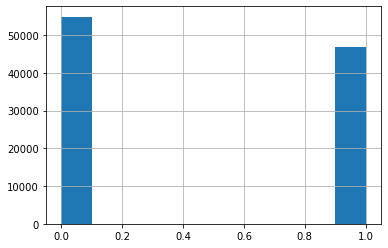

In [96]:
readmitted_lab1.hist()

##### LabelBinarizer

### Enlever les outlayers

### Features selection

In [97]:
diabete.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'change', 'diabetesMed'],
      dtype='object')

In [98]:
oh_admission_type.columns

MultiIndex([(     'Elective',),
            (    'Emergency',),
            (      'Newborn',),
            ('Not Available',),
            (   'Not Mapped',),
            ('Trauma Center',),
            (       'Urgent',),
            (         'cat6',)],
           )

In [99]:
oh_admission_type.sum(axis=0) / len(oh_admission_type)

Elective         0.185416
Emergency        0.530531
Newborn          0.000098
Not Available    0.047020
Not Mapped       0.003144
Trauma Center    0.000206
Urgent           0.181593
cat6             0.051992
dtype: float64

<span class="burk">On va garder les colonnes : Elective, Emergency, Urgent</span>

In [100]:
oh_discharge_disposition.sum(axis=0).sort_values(ascending=False)

Discharged to home                                                                                           60234.0
Discharged/transferred to SNF                                                                                13954.0
Discharged/transferred to home with home health service                                                      12902.0
catNaN                                                                                                        3691.0
Discharged/transferred to another short term hospital                                                         2128.0
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993.0
Expired                                                                                                       1642.0
Discharged/transferred to another type of inpatient care institution                                          1184.0
Not Mapped                                                      

<span class="burk">On va grader les 3 importantes : 
'Discharged to home', 'Discharged/transferred to SNF', 'Discharged/transferred to home with home health service'</span>

In [101]:
oh_discharge_disposition.rename(columns={'Discharged to home':'Discharged_home',
                                         'Discharged/transferred to SNF':'Discharged_SNF',
                                         'Discharged/transferred to home with home health service':'Discharged_home_with_home_health_service'}, 
                                inplace=True)

In [102]:
oh_admission_source.sum(axis=0).sort_values(ascending=False)

 Emergency Room                                               57494.0
 Physician Referral                                           29565.0
catNaN                                                         6781.0
Transfer from a hospital                                       3187.0
 Transfer from another health care facility                    2264.0
Clinic Referral                                                1104.0
 Transfer from a Skilled Nursing Facility (SNF)                 855.0
HMO Referral                                                    187.0
 Not Mapped                                                     161.0
 Not Available                                                  125.0
 Court/Law Enforcement                                           16.0
 Transfer from hospital inpt/same fac reslt in a sep claim       12.0
 Transfer from critial access hospital                            8.0
 Transfer from Ambulatory Surgery Center                          2.0
Normal Delivery     

<span class="burk">On va garder 5 colonnes : 'Emergency Room', 'Physician Referral', 'Transfer from a hospital', 'Transfer from another health care facility', 'Clinic Referral</span>' 

In [103]:
oh_admission_source.rename(columns={' Emergency Room':'Emergency_Room',
                                    ' Physician Referral':'Physician_Referral', 
                                    'Transfer from a hospital':'Transfer_from_hospital',
                                    ' Transfer from another health care facility':'Transfer_health_care_facility',
                                    'Clinic Referral':'Clinic_Referral'}, inplace=True)

In [104]:
oh_insulin.columns = ['insulin_'+i[0] for i in oh_insulin.columns]
oh_insulin.columns

Index(['insulin_Down', 'insulin_No', 'insulin_Steady', 'insulin_Up'], dtype='object')

In [105]:
oh_metformin.columns = ['metformin_'+i[0] for i in oh_metformin.columns]
oh_metformin.columns

Index(['metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up'], dtype='object')

In [106]:
oh_insulin.drop('insulin_Steady', axis=1).columns

Index(['insulin_Down', 'insulin_No', 'insulin_Up'], dtype='object')

In [107]:
diabete_adm = diabete.copy()

**On rassemble les différentes parties et on construit notre dataset**

In [108]:
diabete_adm = pd.concat([diabete_adm, 
           oh_admission_type[['Elective', 'Emergency', 'Urgent']], 
          oh_discharge_disposition[['Discharged_home','Discharged_SNF','Discharged_home_with_home_health_service']],
          oh_admission_source[['Emergency_Room','Physician_Referral','Transfer_from_hospital','Transfer_health_care_facility','Clinic_Referral']],
          oh_metformin.drop('metformin_Steady', axis=1), 
          oh_insulin.drop('insulin_Steady', axis=1)],
          axis=1)

In [148]:
diabete.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,change,diabetesMed
0,0,5,1,41,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,0,1
2,0,25,2,11,5,13,2,0,1,1,1
3,1,35,2,44,1,16,0,0,0,0,1
4,1,45,1,51,0,8,0,0,0,0,1


In [151]:
diabete.describe(include='all')

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,change,diabetesMed
count,101766.000000,101766.0,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
unique,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,26068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.462443,NaN,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,0.538048,0.770031
std,0.498649,NaN,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,0.498553,0.420815
min,0.000000,NaN,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,NaN,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,NaN,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,NaN,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,1.000000,1.000000


## Modèles

### Individu statistique : admission en hôpital

**Construction du dataset d'entrainement**

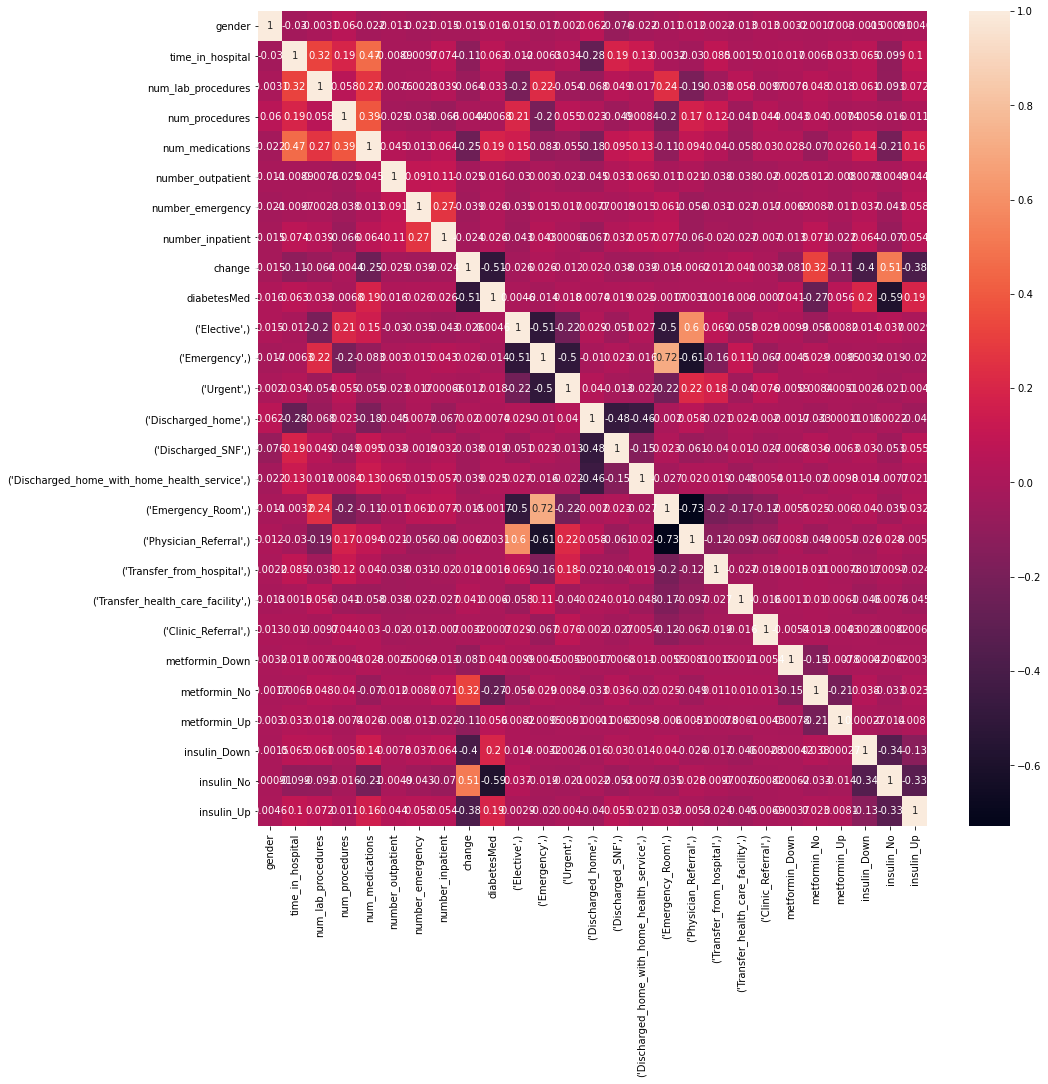

In [111]:
plt.subplots(figsize=(15,15))
sns.heatmap(pd.concat([diabete_adm, readmitted_lab], axis=1).corr(), annot=True);

In [109]:
readmitted_lab

0         0
1         1
2         0
3         0
4         0
         ..
101761    1
101762    0
101763    0
101764    0
101765    0
Name: readmitted, Length: 101766, dtype: category
Categories (3, int64): [2, 1, 0]

#### Modèles

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X = diabete_adm
y = readmitted_lab
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

In [117]:
# Standardiser X_train
scaler =  StandardScaler()

In [119]:
X_train_scal = scaler.fit_transform(X_train)

In [120]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=0)
lg.fit(X_train_scal, y_train)

LogisticRegression(random_state=0)

In [121]:
lg.score(scaler.fit_transform(X_test), y_test)

0.6156239764166394

In [122]:
X = diabete_adm.iloc[:,[1, 5, 7, 8, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
X_train_scaler = scaler.fit_transform(X_train)
lg.fit(X_train_scaler, y_train)

print(lg.score(X_train_scaler, y_train))
print(lg.score(scaler.transform(X_test), y_test))

0.6153068673142793
0.6155912217490992


In [123]:
from joblib import dump, load

In [124]:
# Save the model as a pickle file
filename_pkl_diabete = 'risk_diabete.pkl'
dump(lg, filename_pkl_diabete)

['risk_diabete.pkl']

In [125]:
model_diabete = load("risk_diabete.pkl")

In [126]:
model_diabete.predict_proba(scaler.transform(np.array([65., 16.,  0., 15.,  0.]).reshape((1, 5))))

array([[0.00484672, 0.99515328]])

In [128]:
model_diabete.predict(scaler.transform(np.array([65., 16.,  0., 15.,  0.]).reshape((1, 5))))

array([1], dtype=int64)

In [127]:
filename_pkl_diabete_scaler = 'scaler_diabete.pkl'
dump(scaler, filename_pkl_diabete_scaler)

['scaler_diabete.pkl']

In [136]:
scaler_diabete = joblib.load('scaler_diabete.pkl')
model_diabete = joblib.load("risk_diabete.pkl")
age = 65.
num_medications = 16.
number_emergency = 0.
number_impatient = 15.
Emergency_Room = 0.
X_test_diabete = np.array([age, 
                           num_medications,  
                           number_emergency,
                           number_impatient,  
                           Emergency_Room]).reshape((1, 5))
X_test_diabete_scal = scaler_diabete.transform(X_test_diabete)
readmmission_risk = model_diabete.predict(X_test_diabete_scal)
readmmission_risk_proba = model_diabete.predict_proba(X_test_diabete_scal)[0][1]


In [ ]:
scaler_diabete = joblib.load('scaler_diabete.pkl')
model_diabete = joblib.load("risk_diabete.pkl")
X_test_diabete = np.array([65., 16.,  0., 15.,  0.]).reshape((1, 5))
X_test_diabete_scal = scaler_diabete.transform(X_test_diabete)
readmmission_risk = model_diabete.predict(X_test_diabete_scal)
readmmission_risk_proba = model_diabete.predict_proba(X_test_diabete_scal)[0][1]

In [117]:
from sklearn.svm import SVC
svc = SVC(random_state=0)
print(svc.fit(X_train_scal, y_train).score(scaler.fit_transform(X_test), y_test))

0.581821159515231


In [182]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, 
                        random_state=0)
print(clf.fit(X_train_scal, y_train).score(scaler.fit_transform(X_test), y_test))

0.5396659023910907


In [116]:
from sklearn.tree import DecisionTreeClassifier
# decision tree params 
tre = DecisionTreeClassifier(random_state=0)
print(tre.fit(X_train, y_train).score(X_test, y_test))


0.4625941696691779


In [118]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
print(clf.fit(X_train, y_train).score(X_test, y_test))

0.563937111038323


In [119]:
clf.feature_importances_

array([0.033397  , 0.09286593, 0.11719512, 0.21002363, 0.07450832,
       0.16983073, 0.02638276, 0.01965332, 0.05364293, 0.01970662,
       0.01214444, 0.00943539, 0.01412196, 0.01344836, 0.01517377,
       0.01052783, 0.00964285, 0.00982439, 0.01044501, 0.00326002,
       0.00283805, 0.00239527, 0.00219183, 0.0196216 , 0.00301691,
       0.01172166, 0.02041464, 0.01256965])

Feature: 0, Score: 0.03340
Feature: 1, Score: 0.09287
Feature: 2, Score: 0.11720
Feature: 3, Score: 0.21002
Feature: 4, Score: 0.07451
Feature: 5, Score: 0.16983
Feature: 6, Score: 0.02638
Feature: 7, Score: 0.01965
Feature: 8, Score: 0.05364
Feature: 9, Score: 0.01971
Feature: 10, Score: 0.01214
Feature: 11, Score: 0.00944
Feature: 12, Score: 0.01412
Feature: 13, Score: 0.01345
Feature: 14, Score: 0.01517
Feature: 15, Score: 0.01053
Feature: 16, Score: 0.00964
Feature: 17, Score: 0.00982
Feature: 18, Score: 0.01045
Feature: 19, Score: 0.00326
Feature: 20, Score: 0.00284
Feature: 21, Score: 0.00240
Feature: 22, Score: 0.00219
Feature: 23, Score: 0.01962
Feature: 24, Score: 0.00302
Feature: 25, Score: 0.01172
Feature: 26, Score: 0.02041
Feature: 27, Score: 0.01257


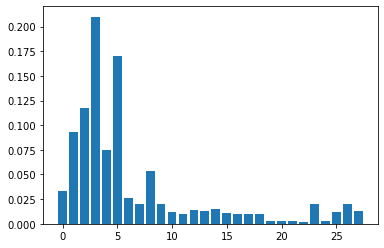

In [120]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [121]:
X = diabete_adm
y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

In [122]:
clf = RandomForestClassifier(random_state=0)
print(clf.fit(X_train, y_train).score(X_test, y_test))

0.5601703242712086


Feature: 0, Score: 0.03264
Feature: 1, Score: 0.09238
Feature: 2, Score: 0.11925
Feature: 3, Score: 0.20944
Feature: 4, Score: 0.07531
Feature: 5, Score: 0.17086
Feature: 6, Score: 0.02663
Feature: 7, Score: 0.02012
Feature: 8, Score: 0.05337
Feature: 9, Score: 0.01910
Feature: 10, Score: 0.01013
Feature: 11, Score: 0.00964
Feature: 12, Score: 0.01420
Feature: 13, Score: 0.01366
Feature: 14, Score: 0.01515
Feature: 15, Score: 0.01088
Feature: 16, Score: 0.00938
Feature: 17, Score: 0.01058
Feature: 18, Score: 0.01086
Feature: 19, Score: 0.00366
Feature: 20, Score: 0.00306
Feature: 21, Score: 0.00255
Feature: 22, Score: 0.00190
Feature: 23, Score: 0.01787
Feature: 24, Score: 0.00281
Feature: 25, Score: 0.01190
Feature: 26, Score: 0.01994
Feature: 27, Score: 0.01273


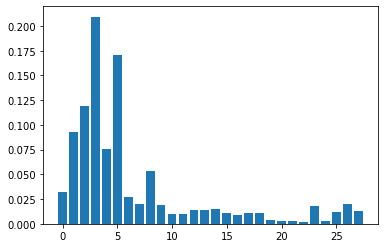

In [123]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [142]:
pd.DataFrame(clf.feature_importances_, 
             index=[i for i,v in enumerate(importance)]).sort_values(0, ascending=False).head(6).index

Int64Index([3, 5, 2, 1, 4, 8], dtype='int64')

In [147]:
diabete_adm.columns

Index([                                     'gender',
                                               'age',
                                  'time_in_hospital',
                                'num_lab_procedures',
                                    'num_procedures',
                                   'num_medications',
                                 'number_outpatient',
                                  'number_emergency',
                                  'number_inpatient',
                                            'change',
                                       'diabetesMed',
                                       ('Elective',),
                                      ('Emergency',),
                                         ('Urgent',),
                                ('Discharged_home',),
                                 ('Discharged_SNF',),
       ('Discharged_home_with_home_health_service',),
                                 ('Emergency_Room',),
                            

In [150]:
X = diabete_adm.iloc[:,[3, 5, 2, 1, 4, 8]]
y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

In [151]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print('train : ', clf.score(X_train, y_train))
print('test : ', clf.score(X_test, y_test))

train :  0.9992840698523219
test :  0.5601703242712086


In [152]:
from sklearn.feature_selection import RFECV

In [154]:
selector = RFECV(clf, step=1, cv=5)
selector.fit(X_train, y_train)
print('train : ', selector.score(X_train, y_train))
print('test : ', selector.score(X_test, y_test))

train :  0.9992840698523219
test :  0.5590566655748445


In [156]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1])

In [175]:
X = diabete_adm
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
lg.fit(scaler.fit_transform(X_train), y_train)
print(lg.score(scaler.fit_transform(X_train), y_train))
print(lg.score(scaler.fit_transform(X_test), y_test))

0.6216800494132181
0.625810678021618


In [176]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(scaler.fit_transform(X_train), y_train)
print(clf.score(scaler.fit_transform(X_train), y_train))
print(clf.score(scaler.fit_transform(X_test), y_test))

0.6018024594306249
0.6020635440550278


In [177]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print('train : ', clf.score(X_train, y_train))
print('test : ', clf.score(X_test, y_test))

train :  0.9993261833904206
test :  0.6146740910579758


In [179]:
selector = RFECV(clf, step=1, cv=5)
selector.fit(X_train, y_train)
print('train : ', selector.score(X_train, y_train))
print('test : ', selector.score(X_test, y_test))

train :  0.9993261833904206
test :  0.6155912217490992


In [178]:
X_test_scal = scaler.fit_transform(X_test)
selector = RFECV(lg, step=1, cv=5)
selector.fit(X_train_scal, y_train)
print('train : ', selector.score(X_train_scal, y_train))
print('test : ', selector.score(X_test_scal, y_test))

train :  0.5391234768937054
test :  0.5391090730429086


In [180]:
svc.fit(X_train_scal, y_train)
print('train : ', svc.score(X_train_scal, y_train))
print('test : ', svc.score(X_test_scal, y_test))

train :  0.5603206244033916
test :  0.5406812970848346


In [183]:
clf = BaggingClassifier(base_estimator=LogisticRegression(),
                        n_estimators=10, 
                        random_state=0)
clf.fit(X_train_scal, y_train)
print('train : ', clf.score(X_train_scal, y_train))
print('test : ', clf.score(X_test_scal, y_test))

train :  0.5392638553540344
test :  0.5395021290533901


In [ ]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, 
                        random_state=0)
print(clf.fit(X_train_scal, y_train).score(X_test, y_test))
# bagging classifior  model 

param_grid = {
    'base_estimator__max_depth' : range(1,20,2),
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

gridBG = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid)
print('train : ', gridBG.score(X_train_scal, y_train))
print('test : ', gridBG.score(X_test_scal, y_test))
print(gridBG.best_params_)

In [ ]:
clf = BaggingClassifier(base_estimator=LogisticRegression(),
                        n_estimators=10, 
                        random_state=0)
print(clf.fit(X_train_scal, y_train).score(X_test, y_test))
# bagging classifior  model 

param_grid = {
    'base_estimator__max_depth' : range(1,20,2),
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

gridBG = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid)
print('train : ', gridBG.score(X_train_scal, y_train))
print('test : ', gridBG.score(X_test_scal, y_test))
print(gridBG.best_params_)

In [186]:
from sklearn.linear_model import RidgeClassifier

In [189]:
rid = RidgeClassifier()
rid.fit(X_train_scal, y_train)
rid.score(X_test_scal, y_test)

0.5394366197183098

#### Features selection

In [197]:
X = diabete_adm.iloc[:,[0, 1, 2, 3, 4, 5]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
lg.fit(scaler.fit_transform(X_train), y_train)
print(lg.score(scaler.fit_transform(X_train), y_train))
print(lg.score(scaler.fit_transform(X_test), y_test))

0.5428154304003594
0.5449721585325908


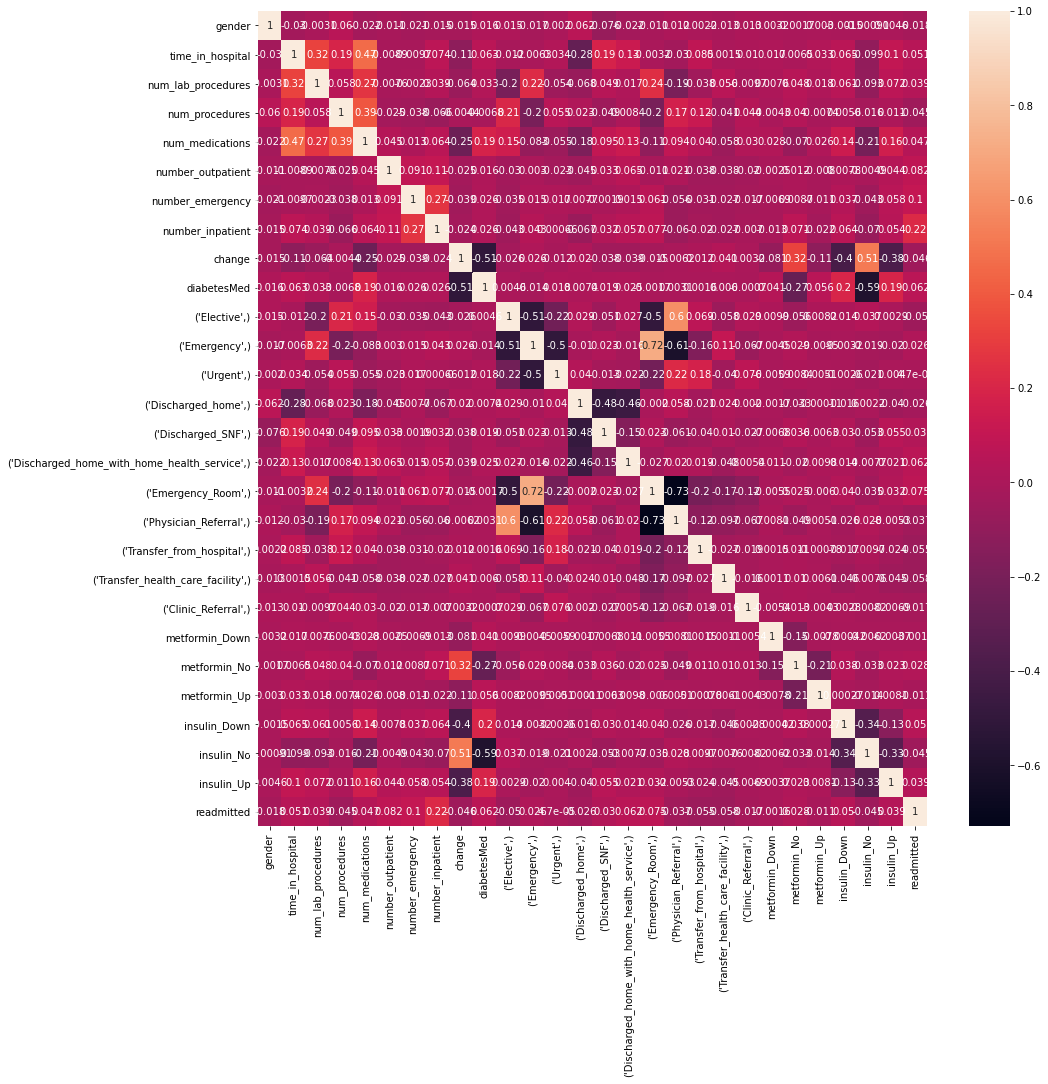

In [198]:
plt.subplots(figsize=(15,15))
sns.heatmap(pd.concat([diabete_adm, readmitted_lab1], axis=1).corr(), annot=True);

In [215]:
pd.concat([diabete_adm, readmitted_lab1], axis=1).corr().iloc[-1,:]

gender                                        -0.018087
time_in_hospital                               0.051289
num_lab_procedures                             0.039253
num_procedures                                -0.044748
num_medications                                0.046772
number_outpatient                              0.082142
number_emergency                               0.103011
number_inpatient                               0.217194
change                                        -0.046008
diabetesMed                                    0.061508
(Elective,)                                   -0.050185
(Emergency,)                                   0.025558
(Urgent,)                                      0.000047
(Discharged_home,)                            -0.025738
(Discharged_SNF,)                              0.030425
(Discharged_home_with_home_health_service,)    0.062430
(Emergency_Room,)                              0.075118
(Physician_Referral,)                         -0

In [210]:
X = diabete_adm[['number_outpatient', 'number_emergency',  'number_inpatient']]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
lg.fit(scaler.fit_transform(X_train), y_train)
print(lg.score(scaler.fit_transform(X_train), y_train))
print(lg.score(scaler.fit_transform(X_test), y_test))

0.6046100286372059
0.6052407468064199


In [ ]:
X = diabete_adm[['number_outpatient', 'number_emergency',  'number_inpatient', '(Emergency,)']]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
crf = RandomForestClassifier()
crf.fit(scaler.fit_transform(X_train), y_train)
print(crf.score(scaler.fit_transform(X_train), y_train))
print(crf.score(scaler.fit_transform(X_test), y_test))

In [236]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X = diabete_adm
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

clf = ExtraTreesClassifier(n_estimators=50)
#clf = clf.fit(X, y)
clf.fit(X_train, y_train)
print('train : ', clf.score(X_train, y_train))
print('test : ', clf.score(X_test, y_test))
print(clf.feature_importances_)

train :  0.9993261833904206
test :  0.6009498853586636
[0.0296109  0.11003347 0.12063207 0.19289537 0.08088322 0.17164153
 0.04501898 0.03179226 0.07827913 0.01265967 0.00563176 0.00672383
 0.00983351 0.00954601 0.01408309 0.00843021 0.00699089 0.00696843
 0.00725708 0.00343944 0.00311619 0.00205643 0.0018891  0.01036914
 0.00261588 0.00674864 0.01303654 0.00781723]


In [237]:
model = SelectFromModel(clf, prefit=True)
#X_new = model.transform(X_train)
#X_new

In [238]:
X_new_train = model.transform(X_train)
X_new_test = model.transform(X_test)
#X_new_test
clf.fit(X_new_train, y_train)
print('train : ', clf.score(X_new_train, y_train))
print('test : ', clf.score(X_new_test, y_test))

train :  0.9697203661070245
test :  0.5661316737635113


In [241]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import BernoulliRBM
mlp = MLPClassifier()
rbm = BernoulliRBM()

In [246]:
#rbm.fit(scaler.fit_transform(X_train), y_train)

In [247]:
#print('train : ', rbm.score(scaler.fit_transform(X_train), y_train))
#print('test  : ', rbm.score(scaler.fit_transform(X_test), y_test))

In [248]:
mlp.fit(scaler.fit_transform(X_train), y_train)
print('train : ', mlp.score(scaler.fit_transform(X_train), y_train))
print('test  : ', mlp.score(scaler.fit_transform(X_test), y_test))

train :  0.6647902745802684
test  :  0.6260072060268588


In [249]:
from sklearn.ensemble import GradientBoostingClassifier

In [250]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

In [251]:
clf.fit(scaler.fit_transform(X_train), y_train)
print('train : ', clf.score(scaler.fit_transform(X_train), y_train))
print('test : ', clf.score(scaler.fit_transform(X_test), y_test))

train :  0.6266213712168005
test :  0.6287913527677694


In [252]:
selector = RFECV(clf, step=1, cv=5)
selector.fit(scaler.fit_transform(X_train), y_train)
print('train : ', selector.score(scaler.fit_transform(X_train), y_train))
print('test : ', selector.score(scaler.fit_transform(X_test), y_test))

train :  0.6267898253691954
test :  0.6290861447756305


In [255]:
selector.ranking_

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 1, 1, 1, 4, 1, 1, 1,
       5, 1, 1, 1, 1, 1])

Feature: 0, Score: 0.00037
Feature: 1, Score: 0.01524
Feature: 2, Score: 0.01160
Feature: 3, Score: 0.01449
Feature: 4, Score: 0.01036
Feature: 5, Score: 0.03556
Feature: 6, Score: 0.05375
Feature: 7, Score: 0.09452
Feature: 8, Score: 0.59392
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.02754
Feature: 11, Score: 0.00651
Feature: 12, Score: 0.01408
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01155
Feature: 15, Score: 0.00732
Feature: 16, Score: 0.01875
Feature: 17, Score: 0.03945
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.01473
Feature: 20, Score: 0.01210
Feature: 21, Score: 0.00101
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00886
Feature: 24, Score: 0.00042
Feature: 25, Score: 0.00346
Feature: 26, Score: 0.00301
Feature: 27, Score: 0.00140


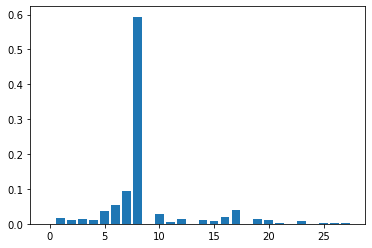

In [258]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [260]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00037
Feature: 1, Score: 0.01524
Feature: 2, Score: 0.01160
Feature: 3, Score: 0.01449
Feature: 4, Score: 0.01036
Feature: 5, Score: 0.03556
Feature: 6, Score: 0.05375
Feature: 7, Score: 0.09452
Feature: 8, Score: 0.59392
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.02754
Feature: 11, Score: 0.00651
Feature: 12, Score: 0.01408
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01155
Feature: 15, Score: 0.00732
Feature: 16, Score: 0.01875
Feature: 17, Score: 0.03945
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.01473
Feature: 20, Score: 0.01210
Feature: 21, Score: 0.00101
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00886
Feature: 24, Score: 0.00042
Feature: 25, Score: 0.00346
Feature: 26, Score: 0.00301
Feature: 27, Score: 0.00140


In [261]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

clf.fit(scaler.fit_transform(X_train), y_train)
print('train : ', clf.score(scaler.fit_transform(X_train), y_train))
print('test  : ', clf.score(scaler.fit_transform(X_test), y_test))

train :  0.6193076534336571
test :  0.6218801179168032


In [262]:
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
lg.fit(scaler.fit_transform(X_train), y_train)
print(lg.score(scaler.fit_transform(X_train), y_train))
print(lg.score(scaler.fit_transform(X_test), y_test))

0.6161912516143523
0.6170324271208647


In [263]:
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]].groupby(['age'], as_index=True).count()
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
lg.fit(scaler.fit_transform(X_train), y_train)
print(lg.score(scaler.fit_transform(X_train), y_train))
print(lg.score(scaler.fit_transform(X_test), y_test))

,age,num_medications,number_outpatient,number_emergency,number_inpatient,diabetesMed,"(Emergency_Room,)"
0,5,1,0,0,0,0,0.0
1,15,18,0,0,0,1,1.0
2,25,13,2,0,1,1,1.0
3,35,16,0,0,0,1,1.0
4,45,8,0,0,0,1,1.0


In [329]:
svc = SVC(random_state=0)
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
svc.fit(scaler.fit_transform(X_train), y_train)
print(svc.score(scaler.fit_transform(X_train), y_train))
print(svc.score(scaler.fit_transform(X_test), y_test))

0.6223819417148633
0.6224041925974452


In [341]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
sgd.fit(scaler.fit_transform(X_train), y_train)
print(sgd.score(scaler.fit_transform(X_train), y_train))
print(sgd.score(scaler.fit_transform(X_test), y_test))

0.6046802178673705
0.6053062561415001


In [346]:
rid = RidgeClassifier()
X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
rid.fit(scaler.fit_transform(X_train), y_train)
print(rid.score(scaler.fit_transform(X_train), y_train))
rid.score(scaler.fit_transform(X_test), y_test)

0.6126817901061261


0.6141500163773338

In [327]:
from sklearn.ensemble import VotingClassifier

In [348]:
clf1 = GradientBoostingClassifier(n_estimators=400, learning_rate=1.0,
    max_depth=1, random_state=0)
clf2 = MLPClassifier(random_state=0)
clf3 = RandomForestClassifier(n_estimators=400, random_state=0)
clf4 = LogisticRegression(random_state=0)
clf5 = GaussianNB()
clf6 = SGDClassifier(random_state=0)
clf7 = RidgeClassifier(random_state=0)

eclf = VotingClassifier(
     estimators=[('GrB', clf1), 
                 ('MPL', clf2), 
                 ('RaF', clf3), 
                 ('Log', clf4), 
                 ('GNB', clf5), 
                 ('SGD', clf6), 
                 ('RID', clf7)],
     voting='hard')

X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
eclf.fit(scaler.fit_transform(X_train), y_train)
print(eclf.score(scaler.fit_transform(X_train), y_train))
print(eclf.score(scaler.fit_transform(X_test), y_test))

0.6213571789544612
0.6175237471339666


In [ ]:
clf = RandomForestClassifier()

X = diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10, 17]]
y = readmitted_lab1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)


param_dist = {"n_estimators": range(10,500,50),
              "max_depth": range(2,10,2),
              "max_features": range(1, X_train.shape[1]+1),
              "min_samples_split": range(2, 11),
#              "bootstrap": [True, False],
#              "criterion": ["gini", "entropy"]
             }

gridRF = GridSearchCV(clf, param_dist)
gridRF.fit(X_train, y_train)

print(gridRF.score(X_train, y_train))
print(gridRF.score(X_test, y_test))

### Individu statistique : patient

In [283]:
X_1 = pd.concat([diabetes.iloc[:, 1],
          diabete_adm.iloc[:,[1, 5, 6, 7, 8, 10]]], 
          axis=1).groupby(['patient_nbr']).agg({'num_medications':'mean', 
                                                'number_outpatient' : 'sum', 
                                                'number_emergency' : 'sum', 
                                                'diabetesMed':'mean'})

In [289]:
y_1 = pd.concat([diabetes.iloc[:, 1],
          pd.get_dummies(diabetes.iloc[:, -1])], 
          axis=1).groupby(['patient_nbr']).count()

In [291]:
y_1.columns

Index(['<30', '>30', 'NO'], dtype='object')

In [324]:
y_1['target'] =y_1['<30'] + y_1['>30'] + y_1['NO']

In [325]:
y_r = scaler.fit_transform(y_1)

In [326]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_1, y_r, shuffle=True, test_size=0.3, random_state=42)
lr.fit(scaler.fit_transform(X_train), y_train)
print(lr.score(scaler.fit_transform(X_train), y_train))
print(lr.score(scaler.fit_transform(X_test), y_test))

0.21828743878484466
0.21726351152362294
